<a href="https://colab.research.google.com/github/nesmachnow/Curso-GANs/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de WGAN-GP
Referencia: https://arxiv.org/pdf/1704.00028.pdf


In [1]:
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
!nvidia-smi

Wed Oct 27 16:02:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
MODEL_NAME = 'WGAN-GP'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [9]:
def get_sample_image(G, n_noise=100):
    """
        100 imágenes de ejemplo
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [10]:
class Critic(nn.Module):
    """
        Crítico: ANN convolucional
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Critic, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_size+condition_size, 784),
            nn.LeakyReLU(0.2),
        )
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
#           nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
#           nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
#           nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
        )
    
    def forward(self, x, c=None):
        # x: (N, 1, 28, 28), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        v = torch.cat((x, c), 1) # v: (N, 794)
        y_ = self.transform(v) # (N, 784)
        y_ = y_.view(y_.shape[0], 1, 28, 28) # (N, 1, 28, 28)
        y_ = self.conv(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [11]:
class Generator(nn.Module):
    """
        Generador: ANN convolucional
    """
    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size+condition_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4x4, output: 7x7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
#           nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7x7, output: 14x14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
#           nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14x14, output: 28x28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, c):
        # x: (N, 100), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        v = torch.cat((x, c), 1) # v: (N, 110)
        y_ = self.fc(v)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_) # (N, 28, 28)
        return y_

In [12]:
C = Critic().to(DEVICE)
G = Generator().to(DEVICE)
# C.load_state_dict('C_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [14]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [15]:
batch_size = 64

In [16]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

In [18]:
C_opt = torch.optim.Adam(C.parameters(), lr=0.0001, betas=(0., 0.9))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0., 0.9))

In [19]:
max_epoch = 100 # se necesitan más de 20 para entrenar el generador
step = 0
n_noise = 100
p_coeff = 10 # lambda
n_critic = 5

In [20]:
C_labels = torch.ones([batch_size, 1]).to(DEVICE) # Etiqueta del crítico/discriminador para real
C_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Etiqueta del crítico/discriminador para fake

In [21]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [25]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        C.zero_grad()
        ## Entrenar el crítico 
        # Datos reales
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        
        # Muestreo y generación
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        x_fake = G(z, y)
                
        # Penalización de gradientes (e.g. gradientes respecto a x_penalty)
        eps = torch.rand(batch_size, 1, 1, 1).to(DEVICE) # x shape: (64, 1, 28, 28)
        x_penalty = eps*x + (1-eps)*x_fake
        x_penalty = x_penalty.view(x_penalty.size(0), -1)
        p_outputs = C(x_penalty, y)
        # Calcular la suma de gradientes de salidas (outputs) respecto a las entradas (inputs)
        xp_grad = autograd.grad(outputs=p_outputs, inputs=x_penalty, grad_outputs=C_labels,
                                create_graph=True, retain_graph=True, only_inputs=True)
        grad_penalty = p_coeff * torch.mean(torch.pow(torch.norm(xp_grad[0], 2, 1) - 1, 2))
        
        # Wasserstein loss
        x_outputs = C(x, y)
        z_outputs = C(x_fake, y)
        C_x_loss = torch.mean(x_outputs)
        C_z_loss = torch.mean(z_outputs)
        C_loss = C_z_loss - C_x_loss + grad_penalty
        
        C_loss.backward()
        C_opt.step()        
        if step % n_critic == 0:
            C.zero_grad()
            G.zero_grad()
            # Entrenar el generador
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = C(G(z, y), y)
            G_loss = -torch.mean(z_outputs)

            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, C Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, C_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 9.637537956237793, G Loss: -0.09775851666927338
Epoch: 0/100, Step: 500, D Loss: -18.466516494750977, G Loss: -1.31673002243042
Epoch: 1/100, Step: 1000, D Loss: -15.652986526489258, G Loss: -3.8550539016723633
Epoch: 1/100, Step: 1500, D Loss: -7.102338790893555, G Loss: -8.373885154724121
Epoch: 2/100, Step: 2000, D Loss: -4.048879146575928, G Loss: -9.938067436218262
Epoch: 2/100, Step: 2500, D Loss: -3.5205469131469727, G Loss: -5.086732387542725
Epoch: 3/100, Step: 3000, D Loss: -4.644060134887695, G Loss: -0.3455062508583069
Epoch: 3/100, Step: 3500, D Loss: -5.767862796783447, G Loss: 0.3318641185760498
Epoch: 4/100, Step: 4000, D Loss: -6.053740501403809, G Loss: -3.7968497276306152
Epoch: 4/100, Step: 4500, D Loss: -6.128735542297363, G Loss: -3.55314564704895
Epoch: 5/100, Step: 5000, D Loss: -6.125691890716553, G Loss: -2.442795991897583
Epoch: 5/100, Step: 5500, D Loss: -4.732655048370361, G Loss: -3.8111705780029297
Epoch: 6/100, Step: 6000, 

## Sample

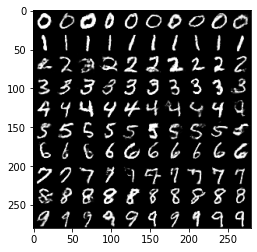

In [26]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [27]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [29]:
# Salvar parámetros
save_checkpoint({'epoch': epoch + 1, 'state_dict':C.state_dict(), 'optimizer' : C_opt.state_dict()}, 'D_gp.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_gp.pth.tar')